## Utilizar otro dataset y poner en práctica la predicción de próxima palabra

# Importo librerias necesarias

In [251]:
import random
import io
import pickle
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [252]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [253]:
# 

import os
import platform

if not os.path.exists('torch_helpers.py'):
    if platform.system() == 'Windows':
        os.system('curl -o torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py')
    else:
        os.system('curl -o torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py')


In [254]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = iter(valid_loader).__next__()
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

# Importo Datos

### Mi idea para este dataset, fue leer un grupo bastante grande de archivos de python (preprocesados y pasados a .txt) con la idea de intentar hacer algo similar a un copilot para ayudar al programador en un caso real)

In [255]:
import pandas as pd
import os

# Folder path containing the .txt files
folder_path = "scriptDatasets"

# List to store the lines from the text files
lines = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="latin-1") as file:  # Specify the appropriate encoding
            for line in file:
                # Remove leading/trailing whitespace and append non-empty lines
                line = line.strip()
                if line:
                    lines.append(line)

# Create a DataFrame from the lines
df = pd.DataFrame({"text": lines})

# Remove spaces at the start and end of each line
df["text"] = df["text"].str.strip()

print(len(df))
df[60:]


3072


,text
60,"# ""y"" (target) se obtiene como cada dato de en..."
61,y = [x * 15 for x in X]
62,"print(""datos X:"", X)"
63,"print(""datos y:"", y)"
64,# Cada dato X lo transformarmos en una matriz ...
...,...
3067,"loss = model3_criterion(y_hat, test_target).it..."
3068,"print(""loss:"", loss)"
3069,"""""""### 4 - ConclusiÃ³n"
3070,El resultado alcanzado es bueno pero podrÃ­a m...


# Pre-Proceso los datos, y tomo como entrenamiento un largo de secuencia de 3 palabras

In [256]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 3

In [257]:
# Concatenamos todos los rows en un solo valor
temp_corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
temp_corpus

'import re import numpy as np import matplotlib.pyplot as plt import seaborn as sns import torch import torch.nn.functional as F import torch.nn as nn from torch.utils.data import Dataset, DataLoader # torchsummar actualmente tiene un problema con las LSTM, por eso # se utiliza torchinfo, un fork del proyecto original con el bug solucionado !pip3 install torchinfo from torchinfo import summary import os import platform if os.access(\'torch_helpers.py\', os.F_OK) is False: if platform.system() == \'Windows\': !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py else: !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100): # Defino listas para realizar graficas de los resultados train_loss = [] valid

### Para poder ayudar a identificar los caracteres, aplico espacios entre los caracteres que no son letras

In [258]:
def add_spaces(script):
    pattern = r'([^a-zA-Z\s])'  # Matches any character that is not a letter or space
    spaced_script = re.sub(pattern, r' \1 ', script)
    return spaced_script

corpus = add_spaces(temp_corpus)
print(corpus)

import re import numpy as np import matplotlib . pyplot as plt import seaborn as sns import torch import torch . nn . functional as F import torch . nn as nn from torch . utils . data import Dataset ,  DataLoader  #  torchsummar actualmente tiene un problema con las LSTM ,  por eso  #  se utiliza torchinfo ,  un fork del proyecto original con el bug solucionado  ! pip 3  install torchinfo from torchinfo import summary import os import platform if os . access (  ' torch _ helpers . py '  ,  os . F _ OK )  is False :  if platform . system (  )   =  =   ' Windows '  :   ! curl  ! wget https :  /  / raw . githubusercontent . com / FIUBA - Posgrado - Inteligencia - Artificial / procesamiento _ lenguaje _ natural / main / scripts / torch _ helpers . py  >  torch _ helpers . py else :   ! wget torch _ helpers . py https :  /  / raw . githubusercontent . com / FIUBA - Posgrado - Inteligencia - Artificial / procesamiento _ lenguaje _ natural / main / scripts / torch _ helpers . py def train ( m

In [259]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[7700:]

['x',
 '2',
 'y',
 'x',
 '1',
 'x',
 '2',
 'for',
 'x',
 'in',
 'x',
 'print',
 'datos',
 'x',
 'x',
 'print',
 'datos',
 'y',
 'y',
 'cada',
 'dato',
 'x',
 'lo',
 'transformarmos',
 'en',
 'una',
 'matriz',
 'de',
 '1',
 'fila',
 '1',
 'columna',
 '1',
 'x',
 '1',
 'x',
 'np',
 'array',
 'x',
 'reshape',
 'len',
 'x',
 '1',
 '1',
 'print',
 'datos',
 'x',
 'x',
 'batch',
 'size',
 'seq',
 'len',
 'input',
 'size',
 'x',
 'shape',
 'y',
 'np',
 'asanyarray',
 'y',
 'y',
 'shape',
 'class',
 'data',
 'dataset',
 'def',
 'init',
 'self',
 'x',
 'y',
 'convertir',
 'los',
 'arrays',
 'de',
 'numpy',
 'a',
 'tensores',
 'pytorch',
 'espera',
 'en',
 'general',
 'entradas',
 '3',
 '2',
 'bits',
 'self',
 'x',
 'torch',
 'from',
 'numpy',
 'x',
 'astype',
 'np',
 'float',
 '3',
 '2',
 'las',
 'loss',
 'unfction',
 'esperan',
 'la',
 'salida',
 'float',
 'self',
 'y',
 'torch',
 'from',
 'numpy',
 'y',
 'astype',
 'np',
 'float',
 '3',
 '2',
 'self',
 'len',
 'self',
 'y',
 'shape',
 '0',
 '

In [260]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 22891


In [261]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [262]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['import', 're', 'import'],
 ['re', 'import', 'numpy'],
 ['import', 'numpy', 'as'],
 ['numpy', 'as', 'np'],
 ['as', 'np', 'import'],
 ['np', 'import', 'matplotlib'],
 ['import', 'matplotlib', 'pyplot'],
 ['matplotlib', 'pyplot', 'as'],
 ['pyplot', 'as', 'plt'],
 ['as', 'plt', 'import'],
 ['plt', 'import', 'seaborn'],
 ['import', 'seaborn', 'as'],
 ['seaborn', 'as', 'sns'],
 ['as', 'sns', 'import'],
 ['sns', 'import', 'torch'],
 ['import', 'torch', 'import'],
 ['torch', 'import', 'torch'],
 ['import', 'torch', 'nn'],
 ['torch', 'nn', 'functional'],
 ['nn', 'functional', 'as']]

In [263]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[30, 340, 30],
 [340, 30, 47],
 [30, 47, 79],
 [47, 79, 31],
 [79, 31, 30],
 [31, 30, 241],
 [30, 241, 242],
 [241, 242, 79],
 [242, 79, 107],
 [79, 107, 30],
 [107, 30, 243],
 [30, 243, 79],
 [243, 79, 72],
 [79, 72, 30],
 [72, 30, 16],
 [30, 16, 30],
 [16, 30, 16],
 [30, 16, 29],
 [16, 29, 244],
 [29, 244, 79]]

In [264]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 22888


input y target

In [265]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [266]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [267]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(22888, 2)
(22888,)


In [268]:
# Palabras del vocabulario
tok.index_word

{1: '1',
 2: 'input',
 3: 'y',
 4: 'size',
 5: 'x',
 6: 'train',
 7: 'test',
 8: 'loss',
 9: 'de',
 10: "'",
 11: 'model',
 12: 'self',
 13: '2',
 14: '3',
 15: 'output',
 16: 'torch',
 17: '0',
 18: 'valid',
 19: 'la',
 20: 'lstm',
 21: 'set',
 22: 'data',
 23: 'epoch',
 24: 'ã',
 25: 'print',
 26: 'el',
 27: 'dim',
 28: 'len',
 29: 'nn',
 30: 'import',
 31: 'np',
 32: 'loader',
 33: 'seq',
 34: 'layer',
 35: 'from',
 36: 'history',
 37: '4',
 38: 'en',
 39: 'target',
 40: 'criterion',
 41: 'hat',
 42: 'error',
 43: 'n',
 44: 'rnn',
 45: 'def',
 46: '5',
 47: 'numpy',
 48: 'out',
 49: '6',
 50: 'para',
 51: 'los',
 52: 'helpers',
 53: 'optimizer',
 54: 'length',
 55: 'count',
 56: 'in',
 57: 'que',
 58: 'float',
 59: 'a',
 60: 'las',
 61: 'batch',
 62: 'shape',
 63: 'astype',
 64: '¡',
 65: 'range',
 66: 'una',
 67: '³',
 68: 'accuracy',
 69: 'init',
 70: 'int',
 71: 'hidden',
 72: 'sns',
 73: 'return',
 74: 'f',
 75: 'array',
 76: 'se',
 77: 'epochs',
 78: 'o',
 79: 'as',
 80: 'fc',


In [269]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

711

In [270]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [271]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [272]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 2
Output dim 711


In [273]:
torch.manual_seed(50)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 18311
Tamaño del conjunto de validacion: 4577


# Entreno el modelo, donde ajuste el tamaño de los embeddings a 50 ya que las palabras son cortas y asumo parecidas, al tratarse de codigo

In [274]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()

        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=50, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=50, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))


Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 711]                  --
├─Embedding: 1-1                         [1, 2, 50]                35,600
├─LSTM: 1-2                              [1, 2, 64]                62,976
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 711]                  23,463
├─Softmax: 1-6                           [1, 711]                  --
Total params: 124,119
Trainable params: 124,119
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.50
Estimated Total Size (MB): 0.50

In [275]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 6.521 - Train accuracy 0.051 - Valid Loss 6.510 - Valid accuracy 0.063
Epoch: 2/200 - Train loss 6.445 - Train accuracy 0.128 - Valid Loss 6.458 - Valid accuracy 0.112
Epoch: 3/200 - Train loss 6.406 - Train accuracy 0.166 - Valid Loss 6.439 - Valid accuracy 0.134
Epoch: 4/200 - Train loss 6.376 - Train accuracy 0.197 - Valid Loss 6.414 - Valid accuracy 0.157
Epoch: 5/200 - Train loss 6.358 - Train accuracy 0.214 - Valid Loss 6.403 - Valid accuracy 0.168
Epoch: 6/200 - Train loss 6.349 - Train accuracy 0.221 - Valid Loss 6.398 - Valid accuracy 0.171
Epoch: 7/200 - Train loss 6.348 - Train accuracy 0.222 - Valid Loss 6.397 - Valid accuracy 0.173
Epoch: 8/200 - Train loss 6.348 - Train accuracy 0.222 - Valid Loss 6.397 - Valid accuracy 0.172
Epoch: 9/200 - Train loss 6.347 - Train accuracy 0.223 - Valid Loss 6.398 - Valid accuracy 0.172
Epoch: 10/200 - Train loss 6.346 - Train accuracy 0.224 - Valid Loss 6.395 - Valid accuracy 0.175
Epoch: 11/200 - Train loss 6.

### Analizo resultados train vs valid

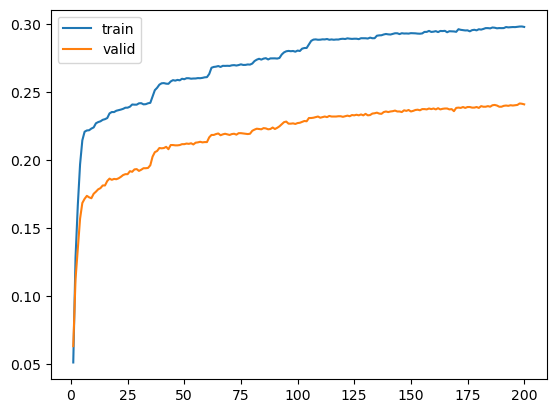

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns 

epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

prediccion

generacion sec n uev        

In [277]:
import sys
!{sys.executable} -m pip install gradio --quiet

In [278]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32))

        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

# Pruebo resultados con partes de codigo CON y SIN espacios entre las palabras, usando cantidades diferentes de outputs

In [279]:
input_texts=[
    "import pandas as",
    "import numpy as"
    "print(",
    "for _ in",
    "model1_optimizer = ",
    "return ",
    "self.lstm_size",
    "class " 
    "sns.lineplot(x=epoch_count,",
    "if not ",
    "import pandas",
    "print ( ",
    "for _",
    "model1_optimizer = ",
    "return ",
    "self. lstm_size",
    "class " 
    "sns . lineplot ( x = epoch_count ,",
    "if not",
    ]

output_list2 = [generate_seq(model1, tok, result, max_length=6, n_words=2) for result in input_texts] 
output_list3  = [generate_seq(model1, tok, result, max_length=6, n_words=3) for result in input_texts]
output_list5  = [generate_seq(model1, tok, result, max_length=6, n_words=5) for result in input_texts]
output_list8  = [generate_seq(model1, tok, result, max_length=6, n_words=8) for result in input_texts]
df = pd.DataFrame({'Input': input_texts, 'Output_2': output_list2, 'Output_3': output_list3,'Output_5': output_list5,'Output_8': output_list8,})
df

,Input,Output_2,Output_3,Output_5,Output_8
0,import pandas as,import pandas as output output,import pandas as rnn o o,import pandas as py output o o la,import pandas as py output o la la self loss la
1,import numpy asprint(,import numpy asprint( model 3,import numpy asprint( model 3 self,import numpy asprint( output model model x x,import numpy asprint( model 3 self size size s...
2,for _ in,for _ in size data,for _ in data model,for _ in ',for _ in '
3,model1_optimizer =,model1_optimizer = ' 3,model1_optimizer = ' 3 la,model1_optimizer = ' valid hat ' valid,model1_optimizer = ' 3 la epoch loss ' 2 test
4,return,return model model,return model model,return model 3 6 cada sns,return model model
5,self.lstm_size,self.lstm_size 2 2,self.lstm_size import 3 6,self.lstm_size import 3 x import output,self.lstm_size 2 2 2 2 2 2 2 2
6,"class sns.lineplot(x=epoch_count,","class sns.lineplot(x=epoch_count,","class sns.lineplot(x=epoch_count, hat ' '","class sns.lineplot(x=epoch_count, 2 2 2 2 2","class sns.lineplot(x=epoch_count, 2 2 2 2 2 2"
7,if not,if not model model,if not ' 3 test,if not model model,if not ' 3 hat ' valid de print epoch
8,import pandas,import pandas py sns,import pandas py la sns,import pandas py sns 6 import 5,import pandas py py 6 self 6 2 x
9,print (,print ( ' 2,print ( ' 2 test,print ( ' 2 6 2 2,print ( ' 2 6 2 2 2 6 2


### Conclusion
##### Luego de entrenar 100 epocas, observe que la diferencia entre train y test en las métricas distaba bastante, por lo que subi las epochs a 200, de esta manera se nota una mejora en el grafico de la metrica aunque la prediccion aun es bastante pobres, ademas de este cambio tambien modifque los embeddings a un largo de 50, para poder distinguir mas las palabras ya que al tratarde de codigo con palabras bastante cortas y/o similares, es probable que se parezcan bastante. Si bien los resultados en las predicciones probadas son similares a las palabras que pertenecen al codigo, en ningun caso ha acertado a la siguiente palabra careciendo de sentido.

##### Para mejorar este resultado, creo que se podria comenzar por mejora la etapa de pre-procesamiento, por ejemplo reformateando el codigo para saber en que caso colocar un espacio y en que casos no, por ejemplo, evitar los espacios cuando hay dos palabras separadas por un punto, dado que es muy probable se trate de un metodo perteneciente a una clase. Ademas, se podría mejorar la arquitectura, agregando capas o neuronales.